# Define method to assign initial data to a grid bucket

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp

In [2]:
def assign_data(gb, domain, **kwargs):
    """ Method to assign data for flow-transport problems.
    
    Parameters
    gb (pp.GridBucket): Grid bucket
    domain (dict): Specifies the grid boundaries.
        Assumes it contains the keys: xmin, xmax, ymin, ymax.
    kwargs (dict): Dictionary of grid data to be set. 
        Keywords are as follows:
            frac_perm (float, default: 1e3): permeability in fractures
            matrix_perm (float, default: 1): permeability in matrix
            flowdir (str, default: 'E'): Direction of flow.
                           Valid values: 'N', 'E', 'S', 'W'.
            porosity (float, default: 0.2): Porosity.

    """
    kw_f = 'flow'
    kw_t = 'transport'
    
    frac_perm = kwargs.get('frac_perm',1e3)
    matrix_perm = kwargs.get('matrix_perm', 1)
    flowdir = kwargs.get('flowdir', 'E')
    poro = kwargs.get('porosity', 0.2)
    
    tol = 1e-4
    for g, d in gb:
        
        # Assign permeability for matrix and fractures
        if g.dim == gb.dim_max():
            kxx = matrix_perm * np.ones(g.num_cells)
        else:
            kxx = frac_perm * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx)
        
        # Boundary conditions
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:
            
            b_face_centers = g.face_centers[:, b_faces]
            if flowdir in ['W', 'E']:
                axis = 0
                mi, ma = map(domain.get, ['xmin', 'xmax'])
            else:
                axis = 1
                mi, ma = map(domain.get, ['ymin', 'ymax'])
            
            # flowdir in ['E', 'N']
            b_inflow = b_face_centers[axis, :] < mi + tol
            b_outflow = b_face_centers[axis, :] < ma - tol
            
            if flowdir in ['S', 'W']:
                b_inflow, b_outflow = b_outflow, b_inflow
            
            labels = np.array(['neu'] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)
            
            # Set inflow to 1. (Outflow is 0).
            bc_val[b_faces[b_inflow]] = 1
        
        else:
            bc = pp.BoundaryCondition(g)
        
        # Porosity
        if g.dim == gb.dim_max():
            porosity = poro * unity
            aperture = 1
        else:
            porosity = (1 - poro) * unity
            aperture = np.power(1e-4, gb.dim_max() - g.dim)
        
        # Set parameters for flow and transport.
        specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "time_step": 1 / 60,
            "mass_weight": porosity * aperture,
            "t_max": 1 / 3,
            }
        pp.initialize_default_data(g, d, kw_f, specified_parameters)
        pp.initialize_default_data(g, d, kw_t, specified_parameters)
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
    
    for e, d in gb.edges():
        data = {"normal_diffusivity": 2e1}
        if pp.PARAMETERS not in d:
            d[pp.PARAMETERS] = pp.Parameters(keywords=['flow_param_edge'], dictionaries=[data])
        else:
            d[pp.PARAMETERS].update_dictionaries(['flow_param_edge'], [data])
        d[pp.PARAMETERS].update_dictionaries([kw_f, kw_t], [{}, {}])
        
        
        if pp.DISCRETIZATION_MATRICES not in d:
            d[pp.DISCRETIZATION_MATRICES] = {}
            
        d[pp.DISCRETIZATION_MATRICES][kw_f] = {}
        d[pp.DISCRETIZATION_MATRICES][kw_t] = {}

    return gb

# Test the above function 

In [3]:
# Create a simple mesh
p = np.array([[0, 2, 1, 1], [0, 0, 0, 1]])
e = np.array([[0, 2], [1, 3]])
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}
network_2d = pp.FractureNetwork2d(p, e, domain)
mesh_args = {'mesh_size_frac': 0.2, 
             'mesh_size_bound': 0.3,
             'mesh_size_min': 0.05}
gb = network_2d.mesh(mesh_args)

In [4]:
gb = assign_data(gb, domain)

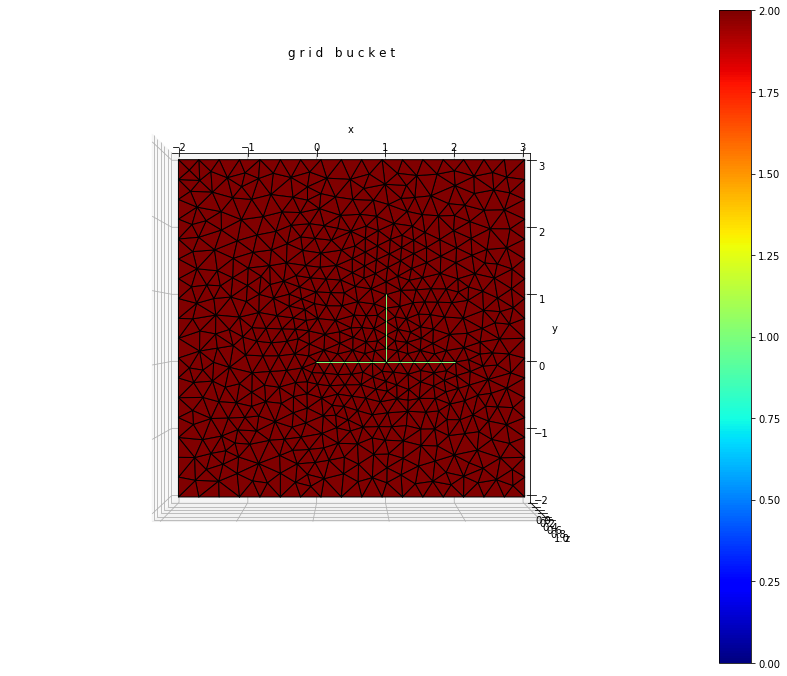

In [5]:
pp.plot_grid(gb, "dimension", figsize=(15, 12))